# Lab 2 - Part A : The Global Race for AI Dominance

In this lab, we will use [artifical intelligence patent dataset](https://www.uspto.gov/ip-policy/economic-research/research-datasets/artificial-intelligence-patent-dataset) provided by USPTO to understand he determinants and impacts of artificial intelligence (AI) invention, and the global race for AI dominance.

In [1]:
library(pacman)
# vtree: sudo apt-get install libcairo2-dev librsvg2-dev
# https://yulab-smu.top/treedata-book/index.html
p_load(readxl, stringr, data.table, magrittr, ggplot2, SPARQL,
        eurostat, XML, RCurl, knitr, vtree, pheatmap)

# color palette
gray_scale <- c('#F3F4F8','#D2D4DA', '#B3B5BD', 
                '#9496A1', '#7d7f89', '#777986', 
                '#656673', '#5B5D6B', '#4d505e',
                '#404352', '#2b2d3b', '#282A3A',
                '#1b1c2a', '#191a2b',
                '#141626', '#101223')

ft_palette <- c('#990F3D', '#0D7680', '#0F5499', '#262A33', '#FFF1E5')

ft_contrast <- c('#F83', '#00A0DD', '#C00', '#006F9B', '#F2DFCE', '#FF7FAA',
                 '#00994D', '#593380')

peep_head <- function(dt, n = 5) {
    dt %>%
        head(n) %>%
        kable()
}

peep_sample <- function(dt, n = 5) {
    dt %>%
        .[sample(.N, n)] %>%
        kable()
}

peep_tail <- function(dt, n = 5) {
    dt %>%
        tail(n) %>%
        kable()
}

In [3]:
aipatents <- fread(cmd = 'unzip -p ../data/ai_model_predictions.tsv.zip ai_model_predictions.tsv')

In [6]:
# 13 million rows, 31 columns
dim(aipatents)

[1] 13244037       31

In [5]:
head(aipatents)

doc_id,flag_patent,pub_dt,appl_id,flag_train_any,predict50_any_ai,flag_train_ml,ai_score_ml,predict50_ml,flag_train_evo,⋯,flag_train_kr,ai_score_kr,predict50_kr,flag_train_planning,ai_score_planning,predict50_planning,flag_train_hardware,ai_score_hardware,predict50_hardware,analysis_phase
<chr>,<int>,<IDate>,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,⋯,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>
20170299591,0,2017-10-19,15377054,0,0,0,0.0002722740,0,0,⋯,0,0.0013027191,0,0,0.0096018314,0,0,0.0023749471,0,1
20170128481,0,2017-05-11,14795790,0,0,0,0.0008636713,0,0,⋯,0,0.0009791255,0,0,0.0008031130,0,0,0.0002642870,0,1
20040254117,0,2004-12-16,09908955,0,0,0,0.0008810759,0,0,⋯,0,0.0003645420,0,0,0.0004195571,0,0,0.0011342168,0,1
20160167428,0,2016-06-16,14160226,0,0,0,0.0019406676,0,0,⋯,0,0.0003758669,0,0,0.0026210546,0,0,0.0005974174,0,1
RE38534,1,2004-06-15,10010151,0,0,0,0.0001583099,0,0,⋯,0,0.0020163655,0,0,0.0005110502,0,0,0.0011628866,0,1
RE38199,1,2003-07-22,10092912,0,0,0,0.0005730987,0,0,⋯,0,0.0006358624,0,0,0.0002709627,0,0,0.0008842945,0,1


In [10]:
# only get patents
aipatents %>%
    .[flag_patent == 1] %>%
    dim()  # only 6.9 million rows left

[1] 6920965      31

In [14]:
# only get patents with and predict50_any_ai == 1
aipatents %>%
    .[flag_patent == 1 & predict50_any_ai == 1] %>%
    str()  # only 6.7 thousand rows left

Classes ‘data.table’ and 'data.frame':	668808 obs. of  31 variables:
 $ doc_id             : chr  "4039258" "4178918" "4084816" "4028686" ...
 $ flag_patent        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pub_dt             : IDate, format: "1977-08-02" "1979-12-18" ...
 $ appl_id            : chr  "05669500" "05833608" "05697725" "05684564" ...
 $ flag_train_any     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ predict50_any_ai   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ flag_train_ml      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ai_score_ml        : num  0.001178 0.010346 0.000421 0.008526 0.061306 ...
 $ predict50_ml       : int  0 0 0 0 0 0 0 1 1 0 ...
 $ flag_train_evo     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ai_score_evo       : num  0.005016 0.009261 0.000357 0.003412 0.001302 ...
 $ predict50_evo      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ flag_train_nlp     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ai_score_nlp       : num  0.000574 0.008563 0.178022 0.00094 0.005659 ...
 $ predict50_nlp      : int  0 0 0 0 0 0 0 1 0 0 ...
 $

In [20]:
# check distribution of category
aipatents %>%
    .[flag_patent == 1 & predict50_any_ai == 1] %>%
    # only keep rows that include 'predict50' in the column name
    # and doc_id, appl_id, and pub_dt
    .[, .SD, .SDcols = c(grep('predict50', names(.), value = TRUE),
                          'doc_id', 'appl_id', 'pub_dt')] %>%
    head()

predict50_any_ai,predict50_ml,predict50_evo,predict50_nlp,predict50_speech,predict50_vision,predict50_kr,predict50_planning,predict50_hardware,doc_id,appl_id,pub_dt
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<IDate>
1,0,0,0,0,0,0,1,0,4039258,05669500,1977-08-02
1,0,0,0,0,0,1,0,0,4178918,05833608,1979-12-18
1,0,0,0,1,0,0,0,0,4084816,05697725,1978-04-18
1,0,0,0,0,0,1,0,0,4028686,05684564,1977-06-07
1,0,0,0,0,0,1,1,0,4084174,05657439,1978-04-11
1,0,0,0,0,0,1,1,0,3970457,05462663,1976-07-20


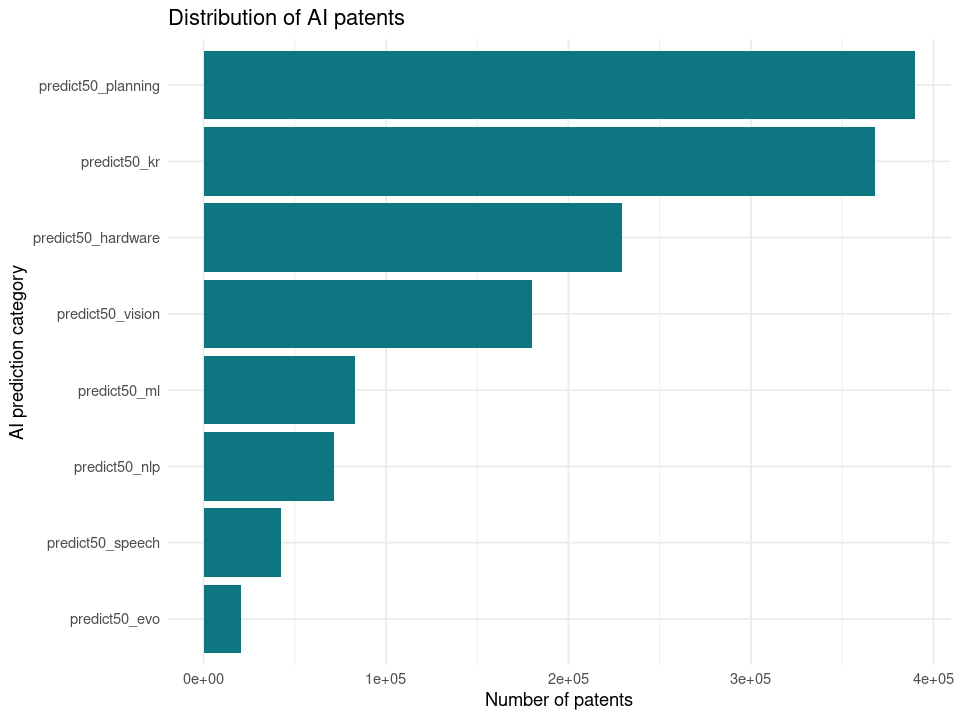

In [37]:
options(repr.plot.width=8, repr.plot.height=6, dpi=400)
aipatents %>%
    .[flag_patent == 1 & predict50_any_ai == 1] %>%
    # only keep rows that include 'predict50' in the column name
    # and doc_id, appl_id, and pub_dt
    .[, .SD, .SDcols = c(grep('predict50', names(.), value = TRUE),
                          'doc_id', 'appl_id', 'pub_dt')] %>%
    # melt the data
    melt(id.vars = c('doc_id', 'appl_id', 'pub_dt')) %>%
    setnames('variable', 'ai_predict') %>%
    .[ai_predict != 'predict50_any_ai'] %>%
    .[value == 1] %>%
    .[, .N, by = .(ai_predict)] %>%
    .[order(-N)] %>%
    # plot the distribution
    ggplot(aes(x = reorder(ai_predict, N), y = N)) +
    geom_bar(stat = 'identity', fill = ft_palette[2]) +
    coord_flip() +
    theme_minimal() +
    # title
    labs(title = 'Distribution of AI patents',
         x = 'AI prediction category',
         y = 'Number of patents')

Here is the full name of categories in the dataset:

- planning: AI planning, scheduling, and optimization
- kr: knowledge representation, reasoning, and processing
- hardware: AI hardware
- ml: machine learning
- vision: computer vision
- nlp: natural language processing
- speech: speech processing
- evo: evolutionary computation

## Trends in AI Invention

Now, we will analyze the trends in AI invention by counting the number of AI patents granted by the USPTO in each year for each category.

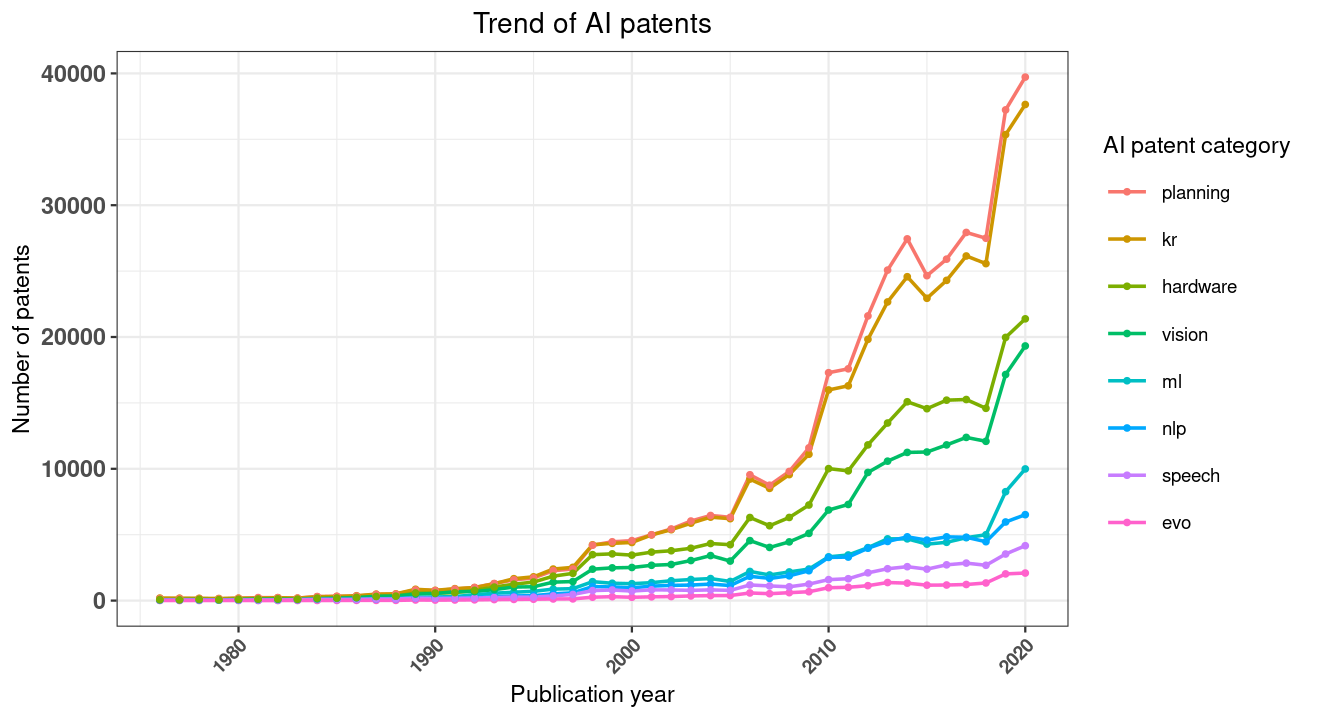

In [74]:
options(repr.plot.width=11, repr.plot.height=6)
aipatents %>%
    .[flag_patent == 1 & predict50_any_ai == 1] %>%
    # only keep rows that include 'predict50' in the column name
    # and doc_id, appl_id, and pub_dt
    .[, .SD, .SDcols = c(grep('predict50', names(.), value = TRUE),
                          'doc_id', 'appl_id', 'pub_dt')] %>%
    # get year from pub_dt, pub_dt is IDate
    .[, pub_year := as.numeric(format(pub_dt, '%Y'))] %>%
    # melt the data
    melt(id.vars = c('doc_id', 'appl_id', 'pub_year')) %>%
    setnames('variable', 'ai_predict') %>%
    .[ai_predict != 'predict50_any_ai'] %>%
    .[value == 1] %>%
    .[, .N, by = .(ai_predict, pub_year)] %>%
    .[order(-pub_year)] %>%
    # replace 'predict50_' with ''
    .[, ai_predict := gsub('predict50_', '', ai_predict)] %>%
    ggplot(aes(x = pub_year, y = N, color = reorder(ai_predict, -N))) +
    geom_line(size=1) +
    geom_point() +
    theme_bw(base_size=14) +
    # title
    labs(title = 'Trend of AI patents',
         x = 'Publication year',
         y = 'Number of patents',
         color = 'AI patent category') +
    theme(
        plot.title=element_text(hjust=0.5),
        axis.text.x=element_text(face='bold', angle=45, hjust=1),
        axis.text.y=element_text(size=14, face='bold'),
        strip.text.x=element_text(size=14),
        legend.key.size = unit(1, 'cm')
        )

## Who is the AI leader?

We have the dataset that only include application number, therefore we need to use the application number to find the assignee name. We will use the assignee name to identify the AI leader.